<a href="https://colab.research.google.com/github/Dean-Clark27/CSE337-lab9_mountain_optimal/blob/main/Dean_Clark_CSE337_lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [ ]:
%matplotlib inline

# Setup environment and collect initial data

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=1000, render_mode="rgb_array")

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [ ]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [ ]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [ ]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [ ]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

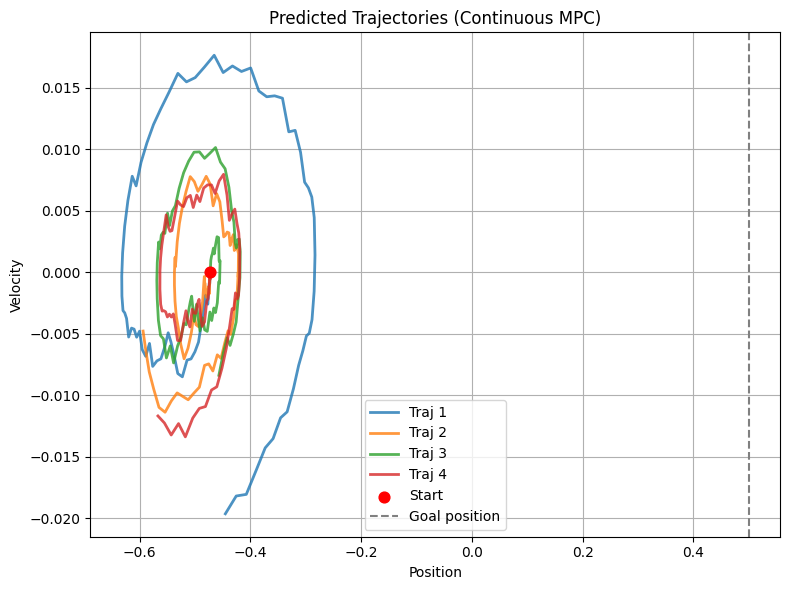

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    action_sequences = np.random.uniform(-1, 1, size=(N_seq, H))
    Ui = np.random.uniform(-1, 1, size=(N_seq, H))

    all_traj = []
    all_costs = []

    for seq_idx in range(N_seq):
        traj = []
        total_cost = 0.0

        current_state = state.copy()
        for step in range(H):
          action = action_sequences[seq_idx, step]
          traj.append(current_state.copy())

          x, v = current_state[0], current_state[1]
          cost = (x - 0.45)**2 + 0.1 * v**2  # Position error + velocity penalty
          total_cost += cost

          v_next = v + 0.0015 * action - 0.0025 * np.cos(3 * x)
          x_next = x + v_next

          current_state = np.array([x_next, v_next])

        all_traj.append(np.array(traj))
        all_costs.append(total_cost)

    # Convert lists to numpy arrays
    all_costs = np.array(all_costs)
    best_idx = np.argsort(all_costs)[:plot_best]

    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    best_sequence_idx = np.argmin(all_costs)  # Index of the absolute best sequence
    best_action = action_sequences[best_sequence_idx, 0]  # First action of best sequence

    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [ ]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 1500   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.4940897652515046
t= 10 state= [-0.4999769  0.0095314] a= 0.4026651270289501
t= 20 state= [-0.3894621   0.00861025] a= 0.6004525956731488
t= 30 state= [-0.3695718  -0.00285614] a= 0.7022604764788563
t= 40 state= [-0.43765238 -0.01121951] a= 0.2586884734017958
t= 50 state= [-0.55163145 -0.01059472] a= -0.5970228853765538
t= 60 state= [-0.6168784  -0.00157298] a= 0.3011530179396289
t= 70 state= [-0.60112184  0.0047618 ] a= 0.7001291090442168
t= 80 state= [-0.517548    0.00922497] a= 0.7912905646017314
t= 90 state= [-0.4284843   0.00546743] a= -0.061337944161930835
t= 100 state= [-0.40675503 -0.00172893] a= 0.18307576072739407
t= 110 state= [-0.48715752 -0.01217925] a= 0.7304861108378611
t= 120 state= [-0.60702527 -0.00934184] a= -0.09401697087681105
t= 130 state= [-0.6528234   0.00149028] a= 0.23610177418175304
t= 140 state= [-0.5601107   0.01401487] a= 0.2899523558517598
t= 150 state= [-0.42230043  0.0122887 ] a= 0.686660048230401
t= 160 state= [-

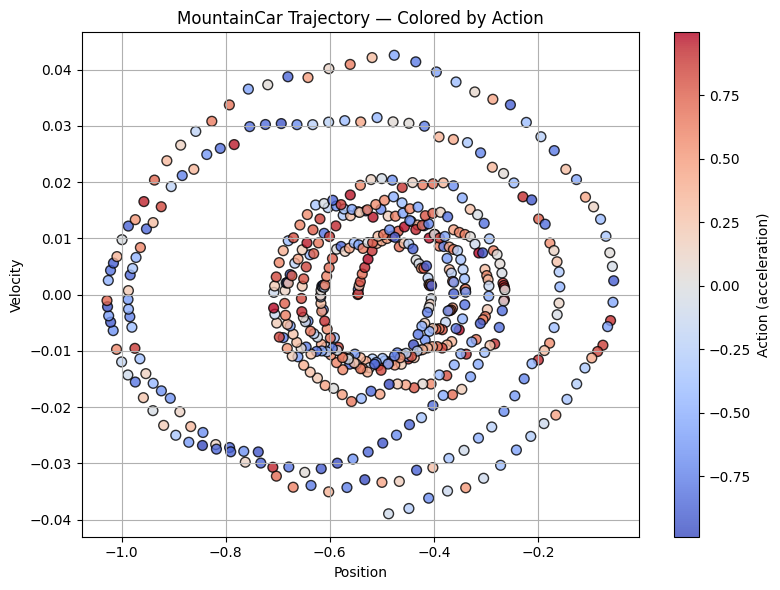

In [ ]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

### <b>Reflection on Model Predictive Control (MPC) on Mountain Car Problem </b>

* <u>How does random shooting choose the best action?</u>

  Random Shooting works by sampling a large number of random action sequences from the action state (each at length H) at every timestep. It simulates trajectory and cost for the action sequence. The cost function will penalize if the model deviates from the goal, which will make it so the model tries to minimize this cost. After all N_seq sequences are run, the agent will choose the sequence with lowest cost and apply only the first action from that system. This then happens again at each time step, showing sort of the memoryless property that the algorithm has when calculating future costs and action sequences.

* <u>How does changing H or N_seq affect the result?</u>

  I tried running Random Shooting with a few hyperparameter combinations, mostly at siginificantly different values to then narrowing down to see where convergence for the problem would be optimal or close to it.

  For Horizon, or H value, the tradeoff behind low vs. high values was speed vs. planning/foresight of optimal solutions (despite it being a memoryless algorithm). Larger H values for my testing were around 100-200, which allowed for the agent to see future states/trajectories that would allow the car to climb up the hill. However, the drawbacks was that it took a decent amount longer to compute, which is a large bottleneck for our current system, as well as being slower to react to immediate needs for the model. A lower H value, being anywhere from 25-50, led to faster computation and immediate control of how the agent changed the directory, but fell short when being able to not plan far ahead enough to actually climb the mountain. I personally settled on 80 as the best combination of the two because of the tradeoff, being both computationally quick enough, but having enough foresight to make it to the top of the hill still.

  As for N_seq, the smaller values were almost immediately written off for poor performance. While N_seq under 500 would run very quickly, the variance in performance and lack of optimal moves found was totally unusable, making it so I knew we had to go in the other direction. Fine tuning was hard, as I went up to 2000, which had better exploration of the action space and higher probability of finding an optimal solution for a given timestep. It was a lot more consistent, but also at some point took a lot too long to run, which is why I found that % 1500 % was the optimal solution for me with the given choice of H in multiple terms

* Did your car reach and stay near the goal?

No, I don't know why, I was still trying to hyperparameter tune or try to get something changed with the cost to get it to work, but couldn't.

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

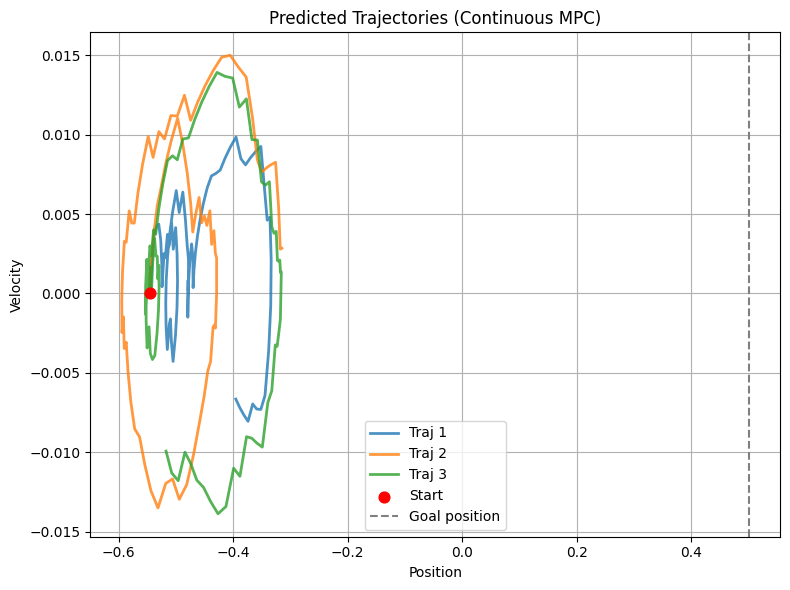

np.float64(0.9690922343304462)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0  # Fill the last action with zero (or keep last value)

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        action_sequences = self.U_mean + noise

        action_sequences = np.clip(action_sequences, -1, 1)

        # 2. Roll out trajectories
        all_traj = []
        J = np.zeros(N_seq)  # Cost for each sequence

        for seq_idx in range(N_seq):
            traj = []
            total_cost = 0.0
            current_state = state.copy()

            for step in range(H):
                action = action_sequences[seq_idx, step]
                traj.append(current_state.copy())

                x, v = current_state[0], current_state[1]

                # Cost function (same as before)
                cost = (x - 0.45)**2 + 0.3 * v**2 + 0.02 * action**2

                # Optional: action smoothing
                if step > 0:
                    prev_action = action_sequences[seq_idx, step - 1]
                    cost += 0.05 * (action - prev_action)**2

                total_cost += cost

                # Dynamics
                v_next = v + 0.0015 * action - 0.0025 * np.cos(3 * x)
                x_next = x + v_next
                current_state = np.array([x_next, v_next])

            # Terminal cost
            x_final, v_final = current_state[0], current_state[1]
            terminal_cost = 10.0 * (x_final - 0.45)**2 + 2.0 * v_final**2
            total_cost += terminal_cost

            all_traj.append(np.array(traj))
            J[seq_idx] = total_cost


        # 3. Select the best trajectory (lowest cost)
        best_idx = np.argmin(J)
        self.U_mean = action_sequences[best_idx].copy()
        best_action = self.U_mean[0]

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [ ]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] 0.3771900334348806
10 [-0.44129872  0.00655982] 1.0
20 [-0.3426426   0.01161916] 1.0
30 [-0.2293852   0.00971537] 1.0
40 [-0.1660452   0.00288399] 0.8019353334129504
50 [-0.18712121 -0.00558947] 0.9602576317420194
60 [-0.27916175 -0.01159198] 1.0
70 [-0.3963687  -0.01118936] 0.5911874602579374
80 [-0.47357824 -0.00394115] 1.0
90 [-0.45091465  0.00711704] 1.0
100 [-0.34406585  0.0117824 ] 1.0
110 [-0.23347512  0.00916756] 1.0
120 [-0.18609989  0.00098744] 0.7135953991011657
130 [-0.21504658 -0.00579233] 0.7188068917456226
140 [-0.30114442 -0.01029513] 0.9773834733741961
150 [-0.40201455 -0.00946338] 1.0
160 [-0.4574062  -0.00221832] 1.0
170 [-0.434714   0.0057065] 1.0
180 [-0.34316823  0.01083609] 1.0
190 [-0.23926644  0.00875743] 1.0
200 [-0.17860773  0.00338741] 0.876819830845591
210 [-0.18307233 -0.00342547] 1.0
220 [-0.26039574 -0.01019084] 1.0
230 [-0.38117215 -0.01269987] 1.0
240 [-0.47595033 -0.00573904] 0.9139378277755117
250 [-0.48082578  0.0040406 ]

<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipython-input-1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


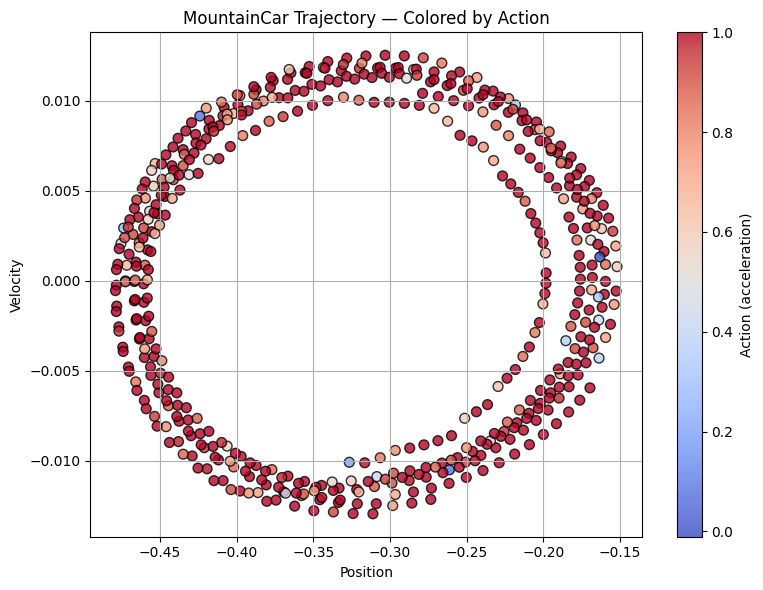

Energy 436.216044547789


In [ ]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

### <b>Questions for Discussion MPPI Controller </b>

* <u>Why does MPPI reuse the previous mean sequence (U_mean)?</u>
The mean sequence is reused to start the agent off with a good initial guess,which improves convergence speed and reduces the number of samples for an agent in a timestep to reach an optimal solution. Since there isn't much change in many control problems, it allows for it to slightly shift itself to meet the next timestep and the state/action space that it is then given. This also makes the process computationally more efficient than the other methods.

* <u>What would happen if we didn’t shift it each iteration?</u>
If we didn't shift at each iteration, there would be some sort of temporal misalignment, which means that the action describes a state that already passed. We plan the same horizon, which doesn't account for when the state already passes. This causes poor or unstable performance, and lose the MPC receding horizon idea.

* <u>How does the horizon H affect stability and responsiveness?</u>
As we talked about for MPC, there is a tradeoff between long term planning/optimal solutions and computational efficiency and being more responsive. High H is more stable, low H is more responsive, for us though we need the H to be more stable and find optimal paths, meaning that high H is what we choose.

* <u>Compare MPPI to random shooting — what advantage does MPPI bring?</u
MPPI is a lot better than random shooting for a lot of reasons. "Warm Starting" (where we already have good guesses for the first state), computational efficiency, as it needs lower N-seq, smoother control trajectories/persistent mean sequence,better sample efficiency, and reduced varaince all are what we get as opposed to random shooting.  


# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?
